<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Deep IV: Use Case and Examples

Deep IV uses deep neural networks in a two-stage instrumental variable (IV) estimation of causal effects, as described in [this ICML publication](http://proceedings.mlr.press/v70/hartford17a/hartford17a.pdf) or in the `econml` [specification](https://econml.azurewebsites.net/spec/estimation/iv.html#deep-instrumental-variables).  In the EconML SDK, we have implemented Deep IV estimation on top of the Keras framework for building and training neural networks.  In this notebook, we'll demonstrate how to use the SDK to apply Deep IV to synthetic data.

### Data

Deep IV works in settings where we have several different types of observations:
* Covariates, which we will denote with `X`
* Instruments, which we will denote with `Z`
* Treatments, which we will denote with `T`
* Responses, which we will denote with `Y`

The main requirement is that `Z` is a set of valid instruments; in particular `Z` should affect the responses `Y` only through the treatments `T`.  We assume that `Y` is an arbitrary function of `T` and `X`, plus an additive error term, and that `T` is an arbitrary function of `Z` and `X`.  Deep IV then allows us to estimate `Y` given `T` and `X`.

### Estimation

To do this, the Deep IV estimator uses a two-stage approach that involves solving two subproblems:
1. It estimates the *distribution* of the treatment `T` given `Z` and `X`, using a mixture density network.
2. It estimates the dependence of the response `Y` on `T` and `X`.

Both of these estimates are performed using neural networks.  See the paper for a more complete description of the setup and estimation approach.

### Using the SDK

In the `econml` package, our Deep IV estimator is built on top of the Keras framework; we support either the Tensorflow or the Theano backends.  There are three steps to using the `DeepIVEstimator`:

1. Construct an instance.  
    * The `m` and `h` arguments to the initializer specify deep neural network models for estimating `T` and `Y` as described above.  They are each *functions* that take two Keras inputs and return a Keras model (the inputs are `z` and `x` in the case of `m` and the output's shape should match `t`'s; the inputs are `t` and `x` in the case of `h` and the output's shape should match `y`'s).  Note that the `h` function will be called multiple times, but should reuse the same weights - see below for a concrete example of how to achieve this using the Keras API.
    * The `n_samples`, `use_upper_bound_loss`, and `n_gradient_samples` arguments together determine how the loss for the response model will be computed.
        * If `use_upper_bound_loss` is `False` and `n_gradient_samples` is zero, then `n_samples` samples will be averaged to approximate the response - this will provide an unbiased estimate of the correct loss only in the limit as the number of samples goes to infinity.
        * If `use_upper_bound_loss` is `False` and `n_gradient_samples` is nonzero, then we will average `n_samples` samples to approximate the response a first time and average `n_gradient_samples` samples to approximate it a second time - combining these allows us to provide an unbiased estimate of the true loss.
        * If `use_upper_bound_loss` is `True`, then `n_gradient_samples` must be `0`; `n_samples` samples will be used to get an unbiased estimate of an upper bound of the true loss - this is equivalent to adding a regularization term penalizing the variance of the response model (see the `econml` specification linked above for a derivation of this fact).
2. Call `fit` with training samples of `Y`, `T`, `X`, and `Z`; this will train both sub-models.
3. Call `effect` or `predict` depending on what output you want.  `effect` calculates the difference in outcomes based on the features and two different treatments, while `predict` predicts the outcome based on a single treatment.

The remainder of this notebook will walk through a concete example.

In [1]:
from econml.deepiv import DeepIVEstimator
import keras
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


## Synthetic data

To demonstrate the Deep IV approach, we'll construct a syntetic dataset obeying the requirements set out above.  In this case, we'll take `X`, `Z`, `T`, and `Y` to come from the following distribution: 

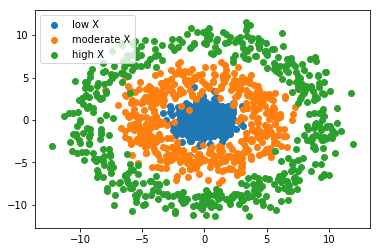

In [2]:
n = 5000

x = np.random.uniform(low=0.0, high=10.0, size=(n,1))
theta = np.random.uniform(low=0.0, high=2 * np.pi, size=(n,1))
z = x * np.cos(theta) + np.random.normal(size=(n,1))
t = x * np.sin(theta) + np.random.normal(size=(n,1))
y = t * t - x * x + np.random.normal(size=(n,1))

plt.scatter(z[x < 1], t[x < 1], label='low X')
plt.scatter(z[(x > 4.5) * (x < 5.5)], t[(x > 4.5) * (x < 5.5)], label='moderate X')
plt.scatter(z[x > 9], t[x > 9], label='high X')
plt.legend()
plt.show()

Here, we'll imagine that `Z` and `X` are causally affecting `T`; as you can see in the plot above, low or high values of `Z` drive moderate values of `T` and moderate values of `Z` cause `T` to have a bi-modal distribution when `X` is high, but a unimodal distribution centered on 0 when `X` is low.  `Y` is a non-linear function of `T` and `X` with no direct dependence on `Z` plus additive noise (as required).  We want to estimate the effect of particular `T` and `X` values on `Y`.

## Defining the neural network models

Now we'll define simple treatment and response models using the Keras `Sequential` model built up of a series of layers.  Each model with have an `input_shape` of 2 (to match the sums of the dimensions of `X` plus `Z` in the treatment case and `T` plus `X` in the response case).

In [3]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

Now we'll instantiate the `DeepIVEstimator` class using these models.  Defining the response model *outside* of the lambda passed into constructor is important, because (depending on the settings for the loss) it can be used multiple times in the second stage and we want the same weights to be used every time.

In [4]:
deepIvEst = DeepIVEstimator(n_components = 10, # number of gaussians in our mixture density network
                            m = lambda z, x : treatment_model(keras.layers.concatenate([z,x])), # treatment model
                            h = lambda t, x : response_model(keras.layers.concatenate([t,x])),  # response model
                            n_samples = 1, # number of samples to use to estimate the response
                            use_upper_bound_loss = False, # whether to use an approximation to the true loss
                            n_gradient_samples = 1, # number of samples to use in second estimate of the response (to make loss estimate unbiased)
                            optimizer='adam', # Keras optimizer to use for training - see https://keras.io/optimizers/ 
                            first_stage_options={"epochs": 100}, # number of epochs to train treatment model
                            second_stage_options={"epochs": 100}) # number of epochs to train response model

## Fitting and predicting using the model
Now we can fit our model to the data:

In [5]:
deepIvEst.fit(Y=y,T=t,X=x,Z=z)

c:\users\kebatt\source\repos\projectalicecore\econml\deepiv.py:327: UserWarning: Output "model_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "model_2" during training.
  model.compile(self._optimizer)


Epoch 1/100
5000/5000 [==============================] - 1s 244us/step - loss: 1.8314
Epoch 2/100
5000/5000 [==============================] - 0s 91us/step - loss: 1.6907
Epoch 3/100
5000/5000 [==============================] - 1s 109us/step - loss: 1.6380
Epoch 4/100
5000/5000 [==============================] - 1s 111us/step - loss: 1.5377
Epoch 5/100
5000/5000 [==============================] - 1s 109us/step - loss: 1.4543
Epoch 6/100
5000/5000 [==============================] - 1s 113us/step - loss: 1.4210
Epoch 7/100
5000/5000 [==============================] - 1s 104us/step - loss: 1.4000
Epoch 8/100
5000/5000 [==============================] - 1s 102us/step - loss: 1.3865
Epoch 9/100
5000/5000 [==============================] - 1s 101us/step - loss: 1.3747
Epoch 10/100
5000/5000 [==============================] - 1s 110us/step - loss: 1.3968
Epoch 11/100
5000/5000 [==============================] - 1s 117us/step - loss: 1.3660
Epoch 12/100
5000/5000 [=============================

5000/5000 [==============================] - 0s 90us/step - loss: 1.2733
Epoch 96/100
5000/5000 [==============================] - 0s 91us/step - loss: 1.2898
Epoch 97/100
5000/5000 [==============================] - 1s 105us/step - loss: 1.2838
Epoch 98/100
5000/5000 [==============================] - 1s 111us/step - loss: 1.2739
Epoch 99/100
5000/5000 [==============================] - 1s 107us/step - loss: 1.2724
Epoch 100/100
5000/5000 [==============================] - 1s 109us/step - loss: 1.2883


c:\users\kebatt\source\repos\projectalicecore\econml\deepiv.py:342: UserWarning: Output "model_8" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "model_8" during training.
  response_model.compile(self._optimizer)


Epoch 1/100
5000/5000 [==============================] - 2s 383us/step - loss: 443.7539
Epoch 2/100
5000/5000 [==============================] - 1s 114us/step - loss: 345.3501
Epoch 3/100
5000/5000 [==============================] - 1s 113us/step - loss: 417.4792
Epoch 4/100
5000/5000 [==============================] - 1s 114us/step - loss: 350.2057
Epoch 5/100
5000/5000 [==============================] - 1s 113us/step - loss: 349.8111
Epoch 6/100
5000/5000 [==============================] - 1s 114us/step - loss: 346.7122
Epoch 7/100
5000/5000 [==============================] - 1s 133us/step - loss: 415.1166
Epoch 8/100
5000/5000 [==============================] - 1s 137us/step - loss: 454.7139
Epoch 9/100
5000/5000 [==============================] - 1s 136us/step - loss: 385.3995
Epoch 10/100
5000/5000 [==============================] - 1s 135us/step - loss: 303.6424
Epoch 11/100
5000/5000 [==============================] - 1s 137us/step - loss: 353.9083
Epoch 12/100
5000/5000 [======

5000/5000 [==============================] - 1s 121us/step - loss: 1964.3794
Epoch 93/100
5000/5000 [==============================] - 1s 120us/step - loss: 1508.7262
Epoch 94/100
5000/5000 [==============================] - 1s 126us/step - loss: 1279.9587
Epoch 95/100
5000/5000 [==============================] - 1s 122us/step - loss: 1299.0377
Epoch 96/100
5000/5000 [==============================] - 1s 122us/step - loss: 718.1291
Epoch 97/100
5000/5000 [==============================] - 1s 115us/step - loss: 624.2269
Epoch 98/100
5000/5000 [==============================] - 1s 144us/step - loss: 644.9171
Epoch 99/100
5000/5000 [==============================] - 1s 189us/step - loss: 762.7121
Epoch 100/100
5000/5000 [==============================] - 1s 148us/step - loss: 764.0998


And now we can create a new set of data and see whether our predicted effect matches the true effect `T*T-X*X`:

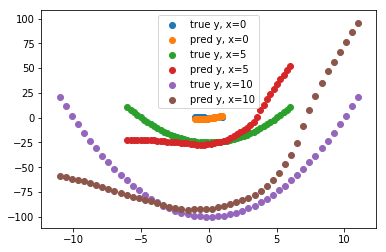

In [6]:
n_test = 500
for x in [0, 5, 10]:
    t = np.linspace(-x-1, x+1)
    y_true = t * t - x * x
    y_pred = deepIvEst.predict(t, np.full_like(t, x))
    plt.scatter(t, y_true, label='true y, x={0}'.format(x))
    plt.scatter(t, y_pred, label='pred y, x={0}'.format(x))
plt.legend()
plt.show()

You can see that despite the fact that the response surface varies with x, our model was able to fit the data reasonably well.